Average duration: 2
Offsets: [ 0  2  4  6  8 11 13 15]
torch.Size([8, 1080, 1920, 3])
torch.Size([8, 3, 1080, 1920])


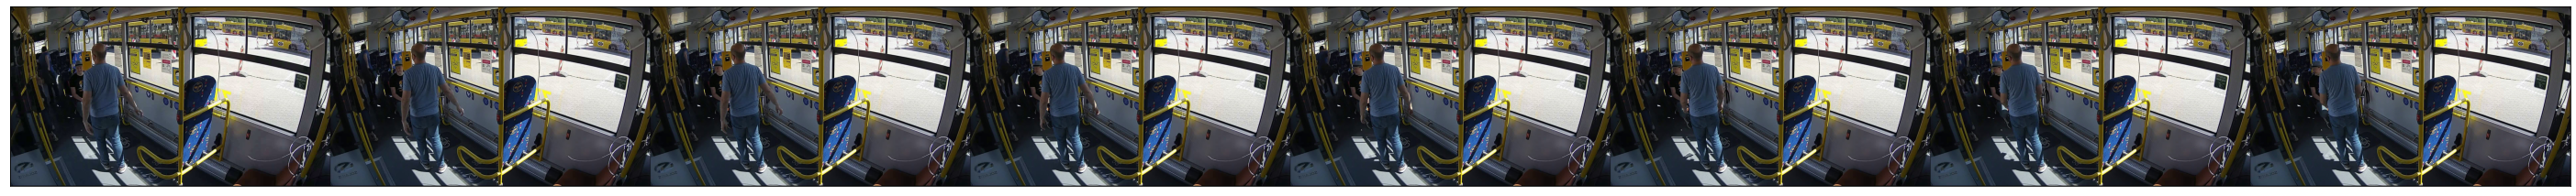

In [2]:
import decord
from decord import VideoReader
from decord import cpu
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
import torch

plt.rcParams["savefig.bbox"] = 'tight'
decord.bridge.set_bridge('torch')

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(50,50))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

num_clips = 8
reader = VideoReader('/mnt/d/serao/bus_dataset/test/Violence/VIOLENCE_1005.avi',ctx=cpu(0))
average_duration = len(reader) // num_clips
offsets = np.multiply(list(range(num_clips)), average_duration) + np.random.randint(average_duration, size=num_clips)

print(f'Average duration: {average_duration}')
print(f'Offsets: {offsets}')

frames = reader.get_batch(offsets)
print(frames.shape)
frames = torch.permute(frames, (0, 3, 1, 2))
print(frames.shape)
# frames = frames.type(torch.float32).div(255)
grid = make_grid(frames)
show(grid)

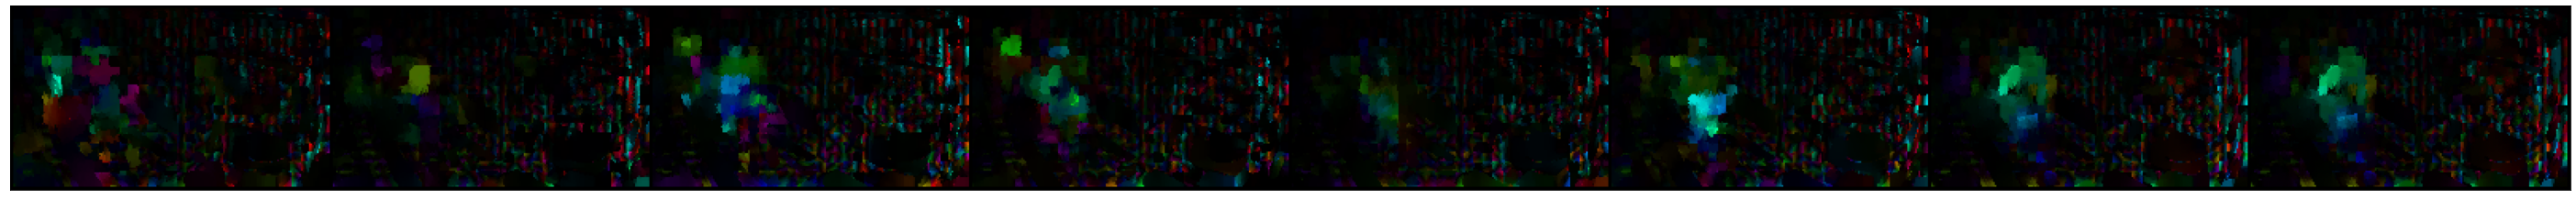

In [12]:
import cv2
import torchvision

resize = torchvision.transforms.Compose([torchvision.transforms.Resize(112)])
to_gray = False

rgb = []
for offset in range(0, frames.shape[0]):
    # Read the next frame
    if offset == (frames.shape[0] - 1):
        offset = offset - 1
        
    prev_frame = frames[offset]
    prev_frame = resize(prev_frame)
    prev_frame = torch.permute(prev_frame, (1,2,0)).numpy()
    next_frame = frames[offset + 1]
    next_frame = resize(next_frame)
    next_frame = torch.permute(next_frame, (1,2,0)).numpy()

    # crate HSV & make Value a constant
    hsv = np.zeros_like(prev_frame)
    hsv[..., 1] = 255
 
    # Preprocessing for exact method
    # if to_gray:
    #     new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical Flow
    flow = cv2.optflow.calcOpticalFlowDenseRLOF(prev_frame, next_frame, None)

    # Encoding: convert the algorithm's output into Polar coordinates
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Use Hue and Value to encode the Optical Flow
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV image into BGR for demo
    opt = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    opt = torch.from_numpy(opt)
    opt = torch.permute(opt, (2,0,1))
    rgb.append(opt)

grid_opt = make_grid(rgb)
show(grid_opt)
